In [198]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from plot_utils import *

def load_data(path) -> Sequence[TimeStepStats]:
    with open(path, "r") as f:
        payload = json.load(f)
    return [TimeStepStats.from_json(x) for x in payload]

dataset = {
    # 'baseline': load_data("../stats/fpm_0_open.json"),
    # 'rprec': load_data("../stats/fpm_0_open_rprec.json"),

    'baseline': load_data("../stats/fpm_0_sliding.json"),
    # 'rprec': load_data("../stats/fpm_0_sliding_rprec.json"),

    # 'baseline': load_data("../stats/fpm_2_sliding.json"),
}
data = dataset['baseline']

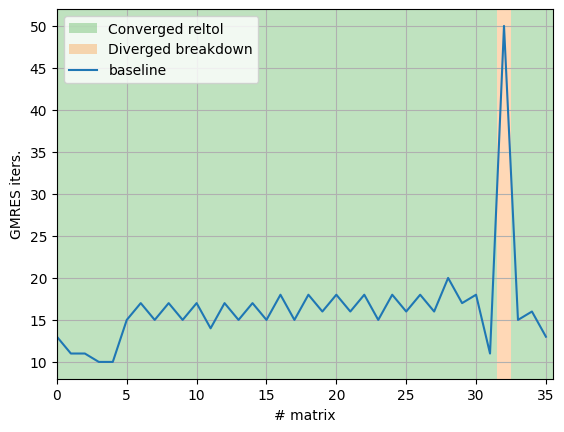

In [199]:
# %matplotlib ipympl
color_converged_reason(data)
for name, data in dataset.items():
    plt.plot(get_gmres_iterations(data), label=name)
    plt.ylabel('GMRES iters.')
    plt.xlabel('# matrix')
    # plt.yscale('log')
plt.legend()

In [200]:
get_gmres_iterations(data)[32]

50

In [202]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


def load_matrix_rhs(data: Sequence[TimeStepStats], idx: int):
    flat_data: list[LinearSolveStats] = [y for x in data for y in x.linear_solves]
    load_dir = Path('../matrices')
    mat = scipy.sparse.load_npz(load_dir / flat_data[idx].matrix_id)
    rhs = np.load(load_dir / flat_data[idx].rhs_id)
    return mat, rhs

mat, rhs = load_matrix_rhs(data, 32)

In [203]:
import porepy as pp
import numpy as np   
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


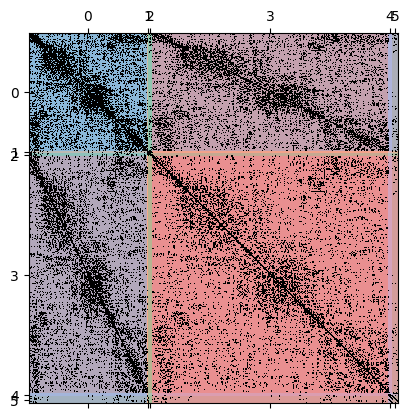

In [204]:
dim_max = model.mdg.dim_max()
sd_ambient = model.mdg.subdomains(dim=dim_max)
sd_lower = [k for i in reversed(range(0, dim_max)) for k in model.mdg.subdomains(dim=i)]
sd_frac = model.mdg.subdomains(dim=dim_max - 1)
intf = model.mdg.interfaces()
intf_frac = model.mdg.interfaces(dim=dim_max - 1)

var_idx = get_variables_indices(
    variable_to_idx=make_variable_to_idx(model),
    md_variables_groups=[
        [model.pressure(sd_ambient)],
        [model.displacement(sd_ambient)],
        [model.pressure(sd_lower)],
        [model.interface_darcy_flux(intf)],
        [model.contact_traction(sd_frac)],
        [model.interface_displacement(intf_frac)],
    ],
)

eq_idx = get_equations_indices(
    equation_to_idx=make_equation_to_idx(model),
    equations_group_order=[
        [("mass_balance_equation", sd_ambient)],  # 0
        [("momentum_balance_equation", sd_ambient)],  # 1
        [("mass_balance_equation", sd_lower)],  # 2
        [("interface_darcy_flux_equation", intf)],  # 3
        [
            ("normal_fracture_deformation_equation", sd_lower),  # 4
            ("tangential_fracture_deformation_equation", sd_lower),
        ],
        [("interface_force_balance_equation", intf)],  # 5
    ],
)

from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(mat=mat, row_idx=eq_dofs, col_idx=var_dofs, groups_row=eq_idx, groups_col=var_idx)
J.color_spy()

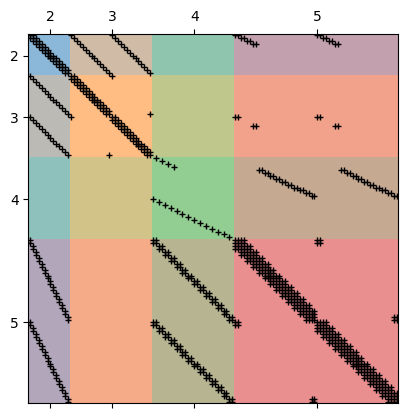

Blocks: (2, 3, 4, 5) cond: 1.06e+21
Solve  took: 0.16
PETSc Converged Reason: -5


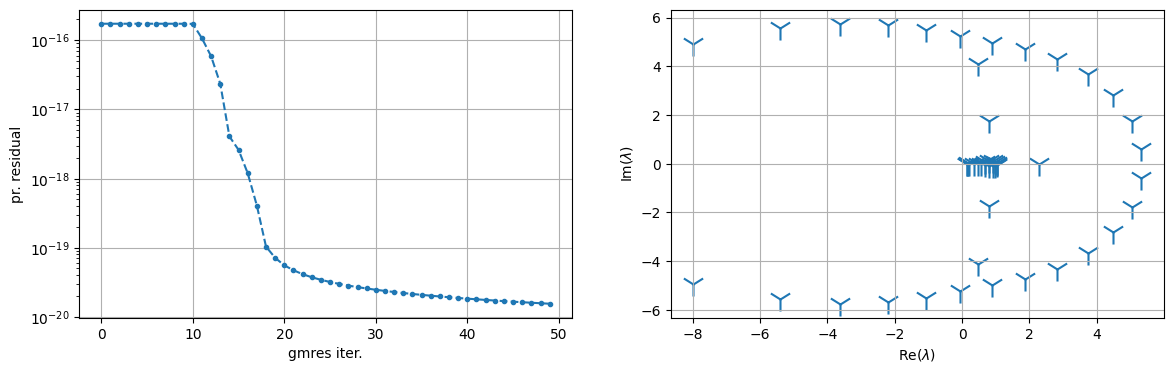

In [215]:
from block_matrix import SolveSchema, make_solver

schema_fixed_stress = SolveSchema(
    groups=[1],
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type="physical",
    # invertor='direct',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),

    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve=lambda bmat: PetscILU(bmat.mat),
    complement=SolveSchema(
        groups=[0],
        solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)

schema_baseline = SolveSchema(
    groups=[2, 3, 4, 5],
    complement=schema_fixed_stress,
    compute_cond=True,
    color_spy=True,
)

# mat_permuted, prec = make_solver(schema=schema_fixed_stress, mat_orig=J)
mat_permuted, prec = make_solver(schema=schema_baseline, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Blocks: (3,) cond: 2.11e+00


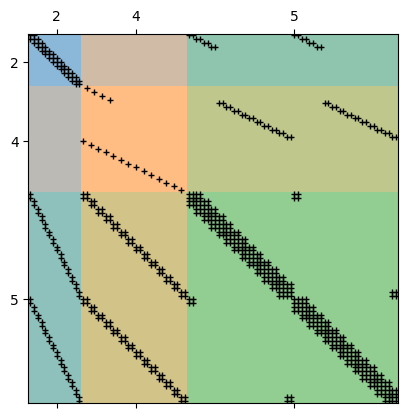

Blocks: (2, 4, 5) cond: 4.33e+13
Solve  took: 0.68


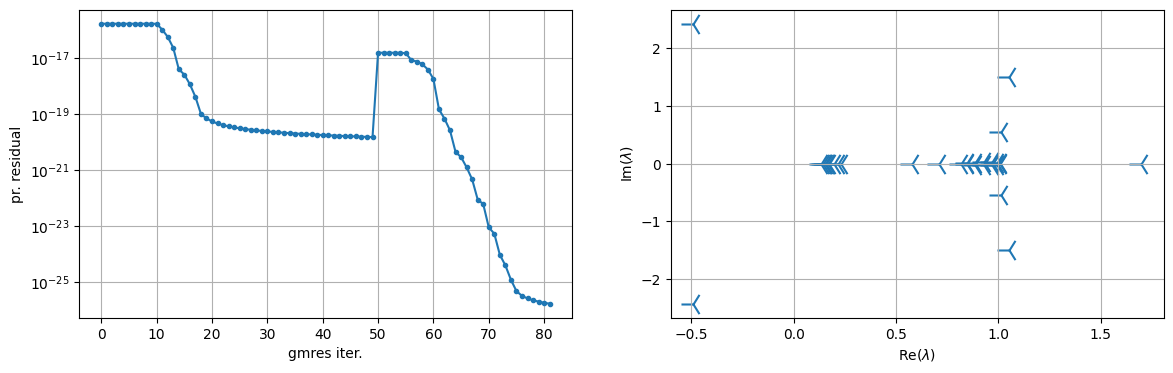

In [217]:
schema_no_flow_intf = SolveSchema(
    color_spy=True,
    compute_cond=True,
    groups=[2, 4, 5],
    complement=schema_fixed_stress,

    # solve=lambda bmat: PetscJacobi(bmat.mat),
    # invertor='direct',
)

schema_1 = SolveSchema(
    compute_cond=True,
    groups=[3],
    solve=lambda bmat: PetscILU(bmat.mat),
    invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=schema_no_flow_intf,
)

mat_permuted, prec = make_solver(schema=schema_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))